# Temporal Lag Feature Engineering

**What**: Use past SST values to predict current conditions

**Why**: El Niño develops over 3-6 months, past values contain predictive signals

**How**: Create 1-week, 1-month, 3-month, 6-month, 12-month lag features

In [10]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
output_csv = 'D:/GitHub/Prediction of El-Nino Events/data/raw/nino.csv'

In [23]:
# Load the CSV file we just created
df = pd.read_csv(output_csv)
df['date'] = pd.to_datetime(df['date']).dt.date  # Remove time part
df = df.set_index('date')

print("Original data shape:", df.shape)
print("\nFirst few rows:")
print(df.head())

Original data shape: (5966, 1)

First few rows:
              sst
date             
1981-09-01  26.65
1981-09-02  26.63
1981-09-03  26.59
1981-09-04  26.40
1981-09-05  26.34


In [24]:
# === CREATE TEMPORAL LAG FEATURES ===

# Create lag features (shift moves data backwards in time)
df['sst_lag_1w'] = df['sst'].shift(7)      # 1 week ago
df['sst_lag_1m'] = df['sst'].shift(30)     # 1 month ago  
df['sst_lag_3m'] = df['sst'].shift(90)     # 3 months ago
df['sst_lag_6m'] = df['sst'].shift(180)    # 6 months ago
df['sst_lag_12m'] = df['sst'].shift(365)   # 12 months ago

print("Features created:")
lag_cols = [col for col in df.columns if 'lag' in col]
for col in lag_cols:
    missing = df[col].isnull().sum()
    print(f"  {col}: {missing} missing values")

print(f"\nDataFrame shape after adding lags: {df.shape}")
print("\nSample data with lag features:")
print(df[['sst'] + lag_cols].head(10))

Features created:
  sst_lag_1w: 7 missing values
  sst_lag_1m: 30 missing values
  sst_lag_3m: 90 missing values
  sst_lag_6m: 180 missing values
  sst_lag_12m: 365 missing values

DataFrame shape after adding lags: (5966, 6)

Sample data with lag features:
              sst  sst_lag_1w  sst_lag_1m  sst_lag_3m  sst_lag_6m  sst_lag_12m
date                                                                          
1981-09-01  26.65         NaN         NaN         NaN         NaN          NaN
1981-09-02  26.63         NaN         NaN         NaN         NaN          NaN
1981-09-03  26.59         NaN         NaN         NaN         NaN          NaN
1981-09-04  26.40         NaN         NaN         NaN         NaN          NaN
1981-09-05  26.34         NaN         NaN         NaN         NaN          NaN
1981-09-06  26.37         NaN         NaN         NaN         NaN          NaN
1981-09-07  26.32         NaN         NaN         NaN         NaN          NaN
1981-09-08  26.30       26.65  

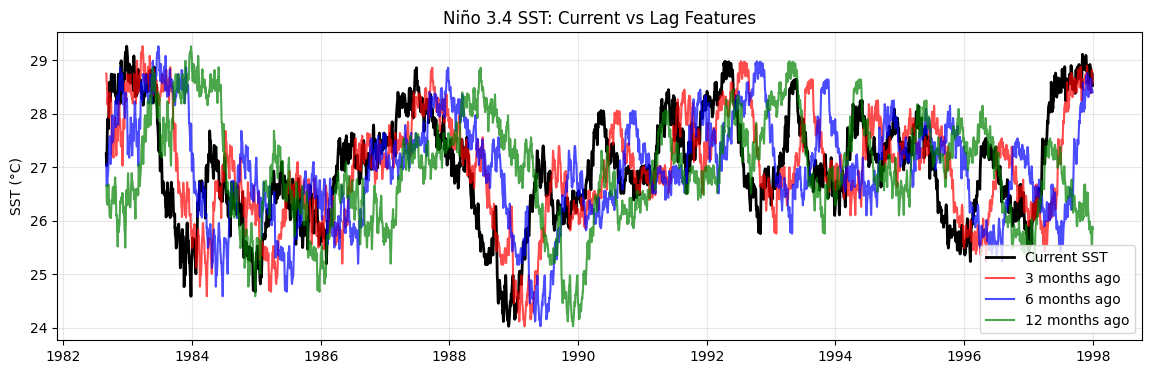

In [ ]:
# === VISUALIZE TEMPORAL LAG FEATURES ===
# Plot 1: Time series comparison

df_plot = df.dropna()  
plt.figure(figsize=(14, 4))
plt.plot(df_plot.index, df_plot['sst'], label='Current SST', color='black', linewidth=2)
plt.plot(df_plot.index, df_plot['sst_lag_3m'], label='3 months ago', color='red', alpha=0.7)
plt.plot(df_plot.index, df_plot['sst_lag_6m'], label='6 months ago', color='blue', alpha=0.7)
plt.plot(df_plot.index, df_plot['sst_lag_12m'], label='12 months ago', color='green', alpha=0.7)

plt.title('Niño 3.4 SST: Current vs Lag Features')
plt.ylabel('SST (°C)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('D:/GitHub/Prediction of El-Nino Events/output/plots/lag_vs_current.png')


Correlation Summary:
1 week: 0.961
1 month: 0.892
3 months: 0.592
6 months: 0.210
12 months: 0.121

Best predictor: 1 week


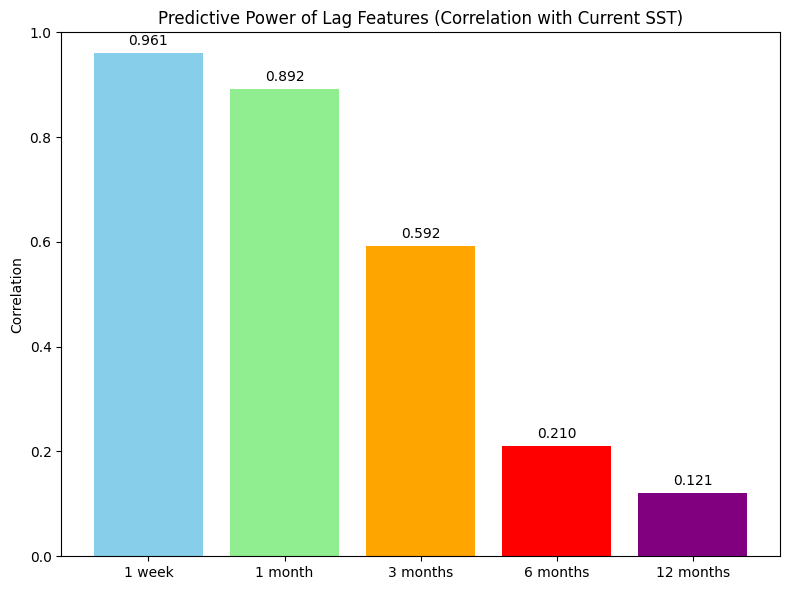

In [49]:
# Plot 2: Correlation analysis

correlations = []
for col in lag_cols:
    corr = df['sst'].corr(df[col])
    correlations.append(corr)

plt.figure(figsize=(8, 6))
lag_names = ['1 week', '1 month', '3 months', '6 months', '12 months']
plt.bar(lag_names, correlations, color=['skyblue', 'lightgreen', 'orange', 'red', 'purple'])
plt.title('Predictive Power of Lag Features (Correlation with Current SST)')
plt.ylabel('Correlation')
plt.ylim(0, 1)

# Add correlation values on bars
for i, v in enumerate(correlations):
    plt.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.savefig('D:/GitHub/Prediction of El-Nino Events/output/plots/lag_correlation.png')

print("\nCorrelation Summary:")
for i, col in enumerate(lag_cols):
    print(f"{lag_names[i]}: {correlations[i]:.3f}")
print(f"\nBest predictor: {lag_names[correlations.index(max(correlations))]}")

# Rolling Statistical Features

**What**: Calculate statistics over moving time windows

**Why Important**:
- **Trend detection**: 30-day average shows warming/cooling trends
- **Volatility**: Standard deviation captures ocean instability
- **Noise reduction**: Smooths daily fluctuations to reveal patterns
- **El Niño precursors**: High volatility often signals upcoming events

In [50]:
# === CREATE ROLLING STATISTICAL FEATURES ===

# Rolling means (trend detection)
df['sst_roll_7d'] = df['sst'].rolling(window=7).mean()      # Weekly average
df['sst_roll_30d'] = df['sst'].rolling(window=30).mean()    # Monthly average
df['sst_roll_90d'] = df['sst'].rolling(window=90).mean()    # Quarterly average

# Rolling standard deviation (volatility detection)
df['sst_vol_7d'] = df['sst'].rolling(window=7).std()       # Weekly volatility
df['sst_vol_30d'] = df['sst'].rolling(window=30).std()     # Monthly volatility

# Rolling min/max (range detection)
df['sst_max_30d'] = df['sst'].rolling(window=30).max()     # 30-day maximum
df['sst_min_30d'] = df['sst'].rolling(window=30).min()     # 30-day minimum
df['sst_range_30d'] = df['sst_max_30d'] - df['sst_min_30d'] # Temperature range

print("Rolling features created:")
rolling_cols = [col for col in df.columns if any(x in col for x in ['roll', 'vol', 'max', 'min', 'range'])]
for col in rolling_cols:
    missing = df[col].isnull().sum()
    print(f"  {col}: {missing} missing values")

print(f"\nTotal features now: {df.shape[1]}")
print("\nSample rolling features:")
print(df[['sst'] + rolling_cols[:5]].head(10))

Rolling features created:
  sst_roll_7d: 6 missing values
  sst_roll_30d: 29 missing values
  sst_roll_90d: 89 missing values
  sst_vol_7d: 6 missing values
  sst_vol_30d: 29 missing values
  sst_max_30d: 29 missing values
  sst_min_30d: 29 missing values
  sst_range_30d: 29 missing values

Total features now: 14

Sample rolling features:
              sst  sst_roll_7d  sst_roll_30d  sst_roll_90d  sst_vol_7d  \
date                                                                     
1981-09-01  26.65          NaN           NaN           NaN         NaN   
1981-09-02  26.63          NaN           NaN           NaN         NaN   
1981-09-03  26.59          NaN           NaN           NaN         NaN   
1981-09-04  26.40          NaN           NaN           NaN         NaN   
1981-09-05  26.34          NaN           NaN           NaN         NaN   
1981-09-06  26.37          NaN           NaN           NaN         NaN   
1981-09-07  26.32    26.471429           NaN           NaN    0.145

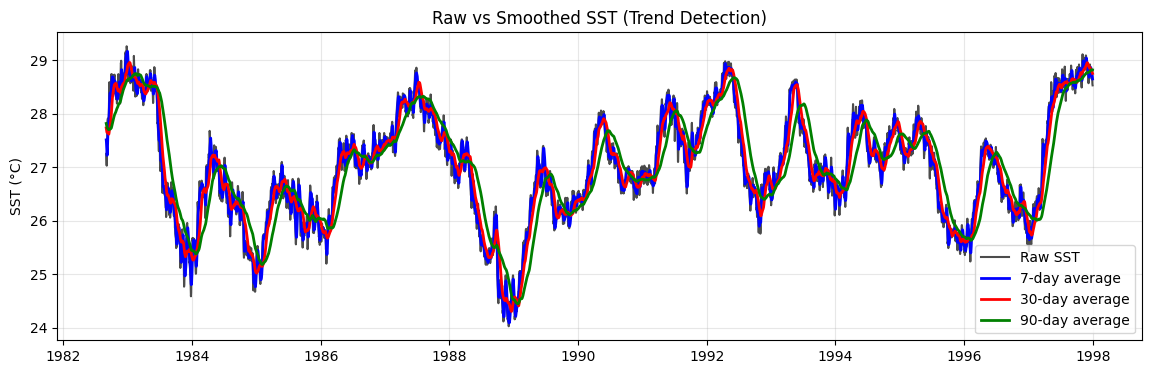

In [ ]:
# === VISUALIZE ROLLING FEATURES ===
# Plot 1: Raw vs Smoothed SST

df_plot = df.dropna()
plt.figure(figsize=(14, 4))
plt.plot(df_plot.index, df_plot['sst'], label='Raw SST', color='black', alpha=0.7)
plt.plot(df_plot.index, df_plot['sst_roll_7d'], label='7-day average', color='blue', linewidth=2)
plt.plot(df_plot.index, df_plot['sst_roll_30d'], label='30-day average', color='red', linewidth=2)

plt.title('Raw vs Smoothed SST (Trend Detection)')
plt.ylabel('SST (°C)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('D:/GitHub/Prediction of El-Nino Events/output/plots/raw_smooth_sst.png')

In [ ]:
# Plot 2: Volatility over time
ax2.plot(df_plot.index, df_plot['sst_vol_7d'], label='7-day volatility', color='orange')
ax2.plot(df_plot.index, df_plot['sst_vol_30d'], label='30-day volatility', color='purple')
ax2.set_title('SST Volatility (El Niño Precursor Signal)')
ax2.set_ylabel('Standard Deviation')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Plot 3: Temperature range
ax3.fill_between(df_plot.index, df_plot['sst_min_30d'], df_plot['sst_max_30d'], 
                 alpha=0.3, color='green', label='30-day range')
ax3.plot(df_plot.index, df_plot['sst'], color='black', alpha=0.8, label='Current SST')
ax3.set_title('30-Day Temperature Range')
ax3.set_ylabel('SST (°C)')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Rolling vs Current correlation
rolling_features = ['sst_roll_7d', 'sst_roll_30d', 'sst_roll_90d', 'sst_vol_30d', 'sst_range_30d']
correlations = [df['sst'].corr(df[col]) for col in rolling_features]
feature_names = ['7d avg', '30d avg', '90d avg', '30d vol', '30d range']

bars = ax4.bar(feature_names, correlations, color=['blue', 'red', 'green', 'orange', 'purple'])
ax4.set_title('Rolling Feature Correlations with Current SST')
ax4.set_ylabel('Correlation')
ax4.set_ylim(0, 1)

# Add values on bars
for bar, corr in zip(bars, correlations):
    height = bar.get_height()
    ax4.text(bar.get_x() + bar.get_width()/2., height + 0.01, f'{corr:.3f}',
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("\\n📊 Rolling Feature Analysis:")
for name, corr in zip(feature_names, correlations):
    print(f"  {name}: {corr:.3f} correlation")
    
print("\\n💡 Key Insights:")
print("• Higher rolling averages = smoother trends")
print("• Volatility spikes often precede El Niño events")
print("• 30-day features balance smoothness vs responsiveness")